In [18]:
"""
Data Preprocessing Pipeline for HCV Disease Prediction
========================================================
This notebook handles:
1. Data cleaning and preparation
2. Feature engineering
3. Handling class imbalance
4. Feature scaling
5. Train/test splitting
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn  # Add this import
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
import pickle

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)  # For reproducibility
pd.set_option('display.max_columns', None)

# Plot settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

✅ Libraries imported successfully
Pandas version: 2.3.2
Scikit-learn version: 1.7.1


In [19]:
# Load the explored data
df = pd.read_csv('../data/hcv_data_explored.csv')

print("="*60)
print("INITIAL DATA ASSESSMENT")
print("="*60)
print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['Category'].value_counts().sort_index())
print(f"\nMissing values: {df.isnull().sum().sum()}")
print(f"\nDuplicate rows: {df.duplicated().sum()}")

INITIAL DATA ASSESSMENT
Dataset shape: (615, 15)

Target distribution:
Category
0=Blood Donor             533
0s=suspect Blood Donor      7
1=Hepatitis                24
2=Fibrosis                 21
3=Cirrhosis                30
Name: count, dtype: int64

Missing values: 32

Duplicate rows: 0


In [20]:
class DataCleaner:
    """Handle data cleaning operations"""
    
    def __init__(self, df):
        self.df = df.copy()
        self.cleaning_report = {}
    
    def remove_duplicates(self):
        """Remove duplicate rows"""
        initial_shape = self.df.shape[0]
        self.df = self.df.drop_duplicates()
        removed = initial_shape - self.df.shape[0]
        self.cleaning_report['duplicates_removed'] = removed
        return self
    
    def handle_missing_values(self, strategy='drop'):
        """Handle missing values with specified strategy"""
        if strategy == 'drop':
            initial_shape = self.df.shape[0]
            self.df = self.df.dropna()
            removed = initial_shape - self.df.shape[0]
            self.cleaning_report['missing_values_removed'] = removed
        return self
    
    def handle_outliers(self, columns=None, n_std=3):
        """Remove outliers beyond n standard deviations"""
        if columns is None:
            # Get numeric columns
            columns = self.df.select_dtypes(include=[np.number]).columns.tolist()
            # Remove 'Category' if it exists in the list
            if 'Category' in columns:
                columns.remove('Category')
        
        outliers_removed = 0
        for col in columns:
            mean = self.df[col].mean()
            std = self.df[col].std()
            
            # Define outlier boundaries
            lower_bound = mean - n_std * std
            upper_bound = mean + n_std * std
            
            # Count outliers
            outliers = self.df[(self.df[col] < lower_bound) | (self.df[col] > upper_bound)]
            outliers_removed += len(outliers)
            
            # Remove outliers (optional - comment out if you want to keep them)
            # self.df = self.df[(self.df[col] >= lower_bound) & (self.df[col] <= upper_bound)]
        
        self.cleaning_report['outliers_found'] = outliers_removed
        return self
    
    def get_clean_data(self):
        """Return cleaned dataframe"""
        print("\n📊 CLEANING REPORT:")
        print("-" * 40)
        for key, value in self.cleaning_report.items():
            print(f"{key}: {value}")
        return self.df

# Apply cleaning
cleaner = DataCleaner(df)
df_clean = cleaner.remove_duplicates().handle_missing_values().handle_outliers().get_clean_data()
print(f"\nCleaned dataset shape: {df_clean.shape}")


📊 CLEANING REPORT:
----------------------------------------
duplicates_removed: 0
missing_values_removed: 26
outliers_found: 92

Cleaned dataset shape: (589, 15)


CLASS IMBALANCE ANALYSIS

Original class distribution:
  0=Blood Donor            :  526 samples ( 89.3%)
  0s=suspect Blood Donor   :    7 samples (  1.2%)
  1=Hepatitis              :   20 samples (  3.4%)
  2=Fibrosis               :   12 samples (  2.0%)
  3=Cirrhosis              :   24 samples (  4.1%)

⚠️ Classes with < 10 samples:
  0s=suspect Blood Donor: 7 samples

📌 Strategy: Merge '0s=suspect Blood Donor' with '1=Hepatitis'

Merged class distribution:
  0=Blood Donor            :  526 samples ( 89.3%)
  1=Hepatitis              :   27 samples (  4.6%)
  2=Fibrosis               :   12 samples (  2.0%)
  3=Cirrhosis              :   24 samples (  4.1%)


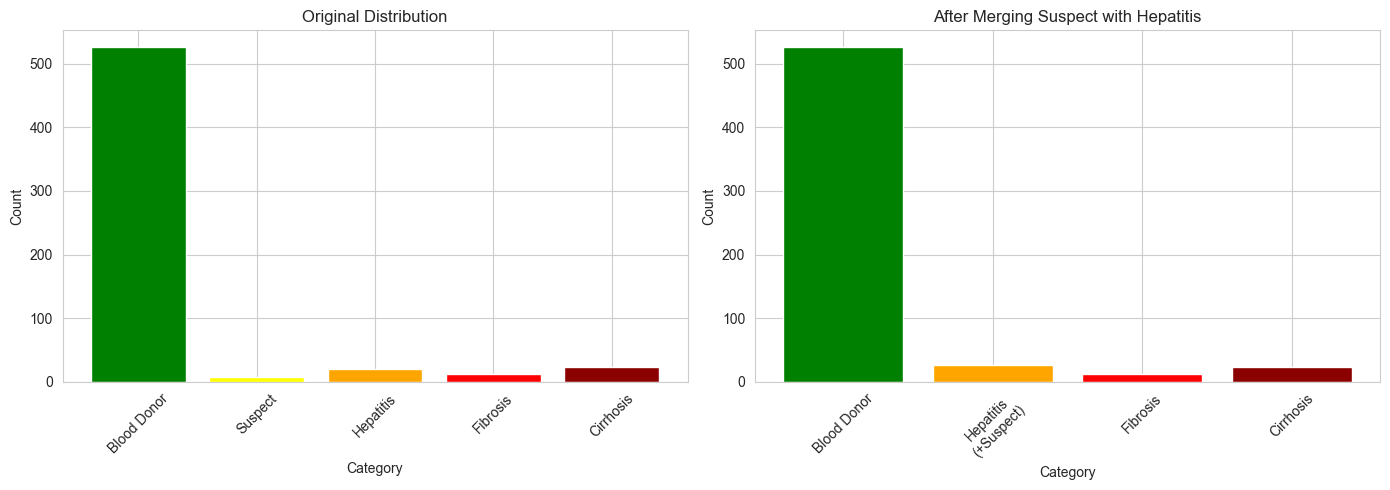

In [21]:
# Analyze class distribution
class_distribution = df_clean['Category'].value_counts().sort_index()

print("="*60)
print("CLASS IMBALANCE ANALYSIS")
print("="*60)
print("\nOriginal class distribution:")
for category, count in class_distribution.items():
    percentage = (count / len(df_clean)) * 100
    print(f"  {category:<25s}: {count:4d} samples ({percentage:5.1f}%)")

# Identify problematic classes
min_samples_threshold = 10
problematic_classes = class_distribution[class_distribution < min_samples_threshold]

if len(problematic_classes) > 0:
    print(f"\n⚠️ Classes with < {min_samples_threshold} samples:")
    for cat, cnt in problematic_classes.items():
        print(f"  {cat}: {cnt} samples")
    print("\n📌 Strategy: Merge '0s=suspect Blood Donor' with '1=Hepatitis'")

# Merge suspect class with hepatitis
df_clean['Category_Merged'] = df_clean['Category'].replace({'0s=suspect Blood Donor': '1=Hepatitis'})

# New distribution
print("\nMerged class distribution:")
merged_distribution = df_clean['Category_Merged'].value_counts().sort_index()
for category, count in merged_distribution.items():
    percentage = (count / len(df_clean)) * 100
    print(f"  {category:<25s}: {count:4d} samples ({percentage:5.1f}%)")

# Visualize before and after
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original distribution
axes[0].bar(range(len(class_distribution)), class_distribution.values, 
           color=['green', 'yellow', 'orange', 'red', 'darkred'])
axes[0].set_title('Original Distribution')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Count')
axes[0].set_xticks(range(len(class_distribution)))
axes[0].set_xticklabels(['Blood Donor', 'Suspect', 'Hepatitis', 'Fibrosis', 'Cirrhosis'], rotation=45)

# Merged distribution
axes[1].bar(range(len(merged_distribution)), merged_distribution.values,
           color=['green', 'orange', 'red', 'darkred'])
axes[1].set_title('After Merging Suspect with Hepatitis')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Count')
axes[1].set_xticks(range(len(merged_distribution)))
axes[1].set_xticklabels(['Blood Donor', 'Hepatitis\n(+Suspect)', 'Fibrosis', 'Cirrhosis'], rotation=45)

plt.tight_layout()
plt.show()

In [22]:
class FeatureEngineer:
    """Create domain-specific and statistical features"""
    
    def __init__(self, df):
        self.df = df.copy()
        self.new_features = []
    
    def create_medical_ratios(self):
        """Create medically relevant ratios"""
        # AST/ALT ratio (De Ritis ratio) - important for liver damage assessment
        self.df['AST_ALT_Ratio'] = self.df['AST'] / (self.df['ALT'] + 1e-5)
        self.new_features.append('AST_ALT_Ratio')
        
        # Albumin/Globulin ratio
        if 'ALB' in self.df.columns and 'PROT' in self.df.columns:
            self.df['ALB_Globulin_Ratio'] = self.df['ALB'] / (self.df['PROT'] - self.df['ALB'] + 1e-5)
            self.new_features.append('ALB_Globulin_Ratio')
        
        # ALP/ALT ratio
        self.df['ALP_ALT_Ratio'] = self.df['ALP'] / (self.df['ALT'] + 1e-5)
        self.new_features.append('ALP_ALT_Ratio')
        
        return self
    
    def create_enzyme_indicators(self):
        """Create binary indicators for abnormal enzyme levels"""
        # Define normal ranges (these are approximate)
        normal_ranges = {
            'ALT': (7, 56),    # IU/L
            'AST': (10, 40),   # IU/L
            'ALP': (44, 147),  # IU/L
            'GGT': (9, 48),    # IU/L
            'BIL': (5, 21),    # μmol/L
        }
        
        for enzyme, (low, high) in normal_ranges.items():
            if enzyme in self.df.columns:
                self.df[f'{enzyme}_Abnormal'] = ((self.df[enzyme] < low) | 
                                                 (self.df[enzyme] > high)).astype(int)
                self.new_features.append(f'{enzyme}_Abnormal')
        
        return self
    
    def create_age_groups(self):
        """Categorize age into clinical groups"""
        bins = [0, 30, 40, 50, 60, 100]
        labels = ['<30', '30-40', '40-50', '50-60', '60+']
        self.df['Age_Group'] = pd.cut(self.df['Age'], bins=bins, labels=labels)
        self.new_features.append('Age_Group')
        return self
    
    def create_severity_score(self):
        """Create composite severity score based on multiple enzymes"""
        # Normalize enzyme levels (0-1 scale)
        enzymes = ['ALT', 'AST', 'GGT', 'ALP']
        for enzyme in enzymes:
            if enzyme in self.df.columns:
                min_val = self.df[enzyme].min()
                max_val = self.df[enzyme].max()
                self.df[f'{enzyme}_norm'] = (self.df[enzyme] - min_val) / (max_val - min_val + 1e-5)
        
        # Composite score (weighted average)
        weights = {'ALT_norm': 0.3, 'AST_norm': 0.3, 'GGT_norm': 0.25, 'ALP_norm': 0.15}
        self.df['Severity_Score'] = sum(self.df[col] * weight 
                                        for col, weight in weights.items() 
                                        if col in self.df.columns)
        self.new_features.append('Severity_Score')
        
        # Remove temporary normalized columns
        temp_cols = [col for col in self.df.columns if col.endswith('_norm')]
        self.df = self.df.drop(columns=temp_cols)
        
        return self
    
    def get_engineered_data(self):
        """Return dataframe with engineered features"""
        print("\n🔧 FEATURE ENGINEERING REPORT:")
        print("-" * 40)
        print(f"Original features: {len(self.df.columns) - len(self.new_features) - 1}")
        print(f"New features created: {len(self.new_features)}")
        print(f"Total features: {len(self.df.columns) - 1}")
        print(f"\nNew features: {', '.join(self.new_features)}")
        return self.df

# Apply feature engineering
engineer = FeatureEngineer(df_clean)
df_engineered = (engineer
                .create_medical_ratios()
                .create_enzyme_indicators()
                .create_age_groups()
                .create_severity_score()
                .get_engineered_data())

# Display sample of new features
print("\nSample of engineered features:")
df_engineered[['AST_ALT_Ratio', 'Severity_Score', 'ALT_Abnormal', 'Age_Group']].head()


🔧 FEATURE ENGINEERING REPORT:
----------------------------------------
Original features: 14
New features created: 10
Total features: 24

New features: AST_ALT_Ratio, ALB_Globulin_Ratio, ALP_ALT_Ratio, ALT_Abnormal, AST_Abnormal, ALP_Abnormal, GGT_Abnormal, BIL_Abnormal, Age_Group, Severity_Score

Sample of engineered features:


,AST_ALT_Ratio,Severity_Score,ALT_Abnormal,Age_Group
0,2.870126,0.035484,0,30-40
1,1.372221,0.055440,0,30-40
2,1.453038,0.107413,0,30-40
3,0.738562,0.065348,0,30-40
4,0.760736,0.075974,0,30-40


In [23]:
def encode_categorical_features(df):
    """Encode categorical variables for ML models"""
    
    df_encoded = df.copy()
    categorical_columns = []
    encoding_mappings = {}
    
    # Encode Sex (binary)
    if 'Sex' in df_encoded.columns:
        le_sex = LabelEncoder()
        df_encoded['Sex_Encoded'] = le_sex.fit_transform(df_encoded['Sex'])
        df_encoded = df_encoded.drop('Sex', axis=1)
        encoding_mappings['Sex'] = dict(zip(le_sex.classes_, le_sex.transform(le_sex.classes_)))
        categorical_columns.append('Sex')
    
    # Encode Age_Group (ordinal)
    if 'Age_Group' in df_encoded.columns:
        age_group_mapping = {'<30': 0, '30-40': 1, '40-50': 2, '50-60': 3, '60+': 4}
        df_encoded['Age_Group_Encoded'] = df_encoded['Age_Group'].map(age_group_mapping)
        df_encoded = df_encoded.drop('Age_Group', axis=1)
        encoding_mappings['Age_Group'] = age_group_mapping
        categorical_columns.append('Age_Group')
    
    print("📝 ENCODING REPORT:")
    print("-" * 40)
    print(f"Categorical columns encoded: {categorical_columns}")
    print(f"\nEncoding mappings:")
    for col, mapping in encoding_mappings.items():
        print(f"  {col}: {mapping}")
    
    return df_encoded, encoding_mappings

# Apply encoding
df_encoded, encoding_maps = encode_categorical_features(df_engineered)
print(f"\nFinal encoded shape: {df_encoded.shape}")

📝 ENCODING REPORT:
----------------------------------------
Categorical columns encoded: ['Sex', 'Age_Group']

Encoding mappings:
  Sex: {'f': np.int64(0), 'm': np.int64(1)}
  Age_Group: {'<30': 0, '30-40': 1, '40-50': 2, '50-60': 3, '60+': 4}

Final encoded shape: (589, 25)


In [24]:
# Separate features and target
target_column = 'Category_Merged'
feature_columns = [col for col in df_encoded.columns if col not in ['Category', 'Category_Merged', 'Unnamed: 0']]

X = df_encoded[feature_columns]
y = df_encoded[target_column]

# Convert target to numeric labels
# First, let's check the unique values in Category_Merged
print("Unique values in Category_Merged:", y.unique())

# Create proper label mapping based on actual category values
label_mapping = {
    '0=Blood Donor': 0,
    '1=Hepatitis': 1,
    '2=Fibrosis': 2,
    '3=Cirrhosis': 3
}
y_numeric = y.map(label_mapping)

print("="*60)
print("FEATURE AND TARGET PREPARATION")
print("="*60)
print(f"Features shape: {X.shape}")
print(f"Target shape: {y_numeric.shape}")
print(f"\nFeature columns ({len(feature_columns)}):")
for i in range(0, len(feature_columns), 4):
    print(f"  {', '.join(feature_columns[i:i+4])}")
print(f"\nTarget classes: {sorted(y_numeric.unique())}")
print(f"Target distribution:\n{y_numeric.value_counts().sort_index()}")

Unique values in Category_Merged: ['0=Blood Donor' '1=Hepatitis' '2=Fibrosis' '3=Cirrhosis']
FEATURE AND TARGET PREPARATION
Features shape: (589, 22)
Target shape: (589,)

Feature columns (22):
  Age, ALB, ALP, ALT
  AST, BIL, CHE, CHOL
  CREA, GGT, PROT, AST_ALT_Ratio
  ALB_Globulin_Ratio, ALP_ALT_Ratio, ALT_Abnormal, AST_Abnormal
  ALP_Abnormal, GGT_Abnormal, BIL_Abnormal, Severity_Score
  Sex_Encoded, Age_Group_Encoded

Target classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Target distribution:
Category_Merged
0    526
1     27
2     12
3     24
Name: count, dtype: int64


TRAIN-VALIDATION-TEST SPLIT (60/20/20)
Total samples: 589
Training set:   353 samples (59.9%)
Validation set: 118 samples (20.0%)
Test set:       118 samples (20.0%)

Total: 589 samples

Class distribution in each set:
----------------------------------------

Train set:
  Class 0: 316 samples ( 89.5%)
  Class 1:  16 samples (  4.5%)
  Class 2:   7 samples (  2.0%)
  Class 3:  14 samples (  4.0%)

Val set:
  Class 0: 105 samples ( 89.0%)
  Class 1:   5 samples (  4.2%)
  Class 2:   3 samples (  2.5%)
  Class 3:   5 samples (  4.2%)

Test set:
  Class 0: 105 samples ( 89.0%)
  Class 1:   6 samples (  5.1%)
  Class 2:   2 samples (  1.7%)
  Class 3:   5 samples (  4.2%)


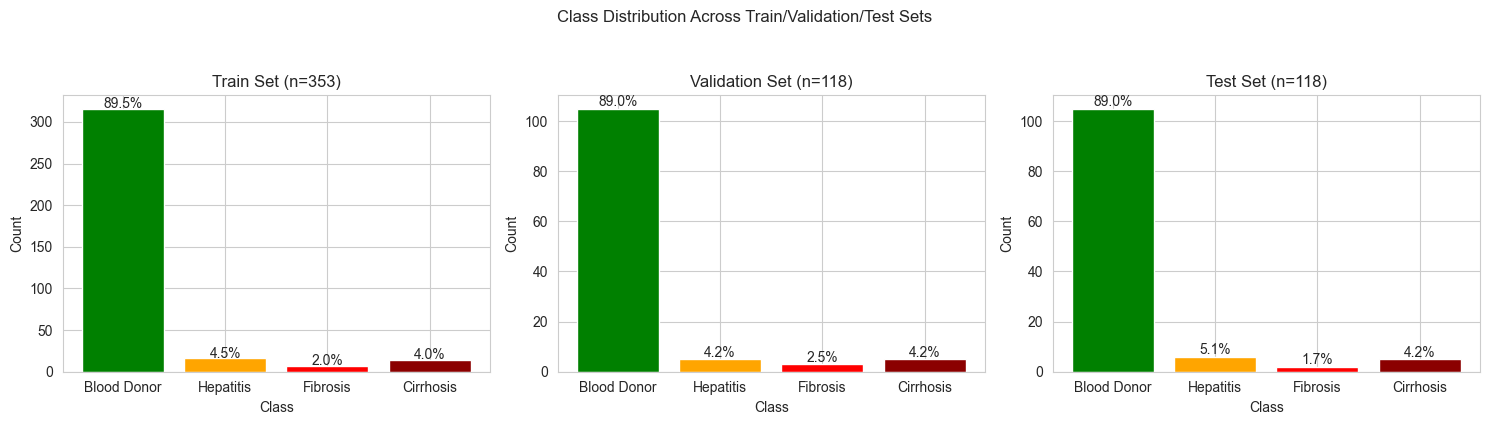

In [25]:
# Implement 60/20/20 train/validation/test split
# First split: 80% for train+val, 20% for test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_numeric, test_size=0.20, random_state=42, stratify=y_numeric
)

# Second split: 75% of temp for train (60% of total), 25% of temp for val (20% of total)
# 60/(60+20) = 0.75 for train from temp
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("="*60)
print("TRAIN-VALIDATION-TEST SPLIT (60/20/20)")
print("="*60)
print(f"Total samples: {len(X)}")
print(f"Training set:   {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTotal: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]} samples")

# Verify the splits add up correctly
assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == len(X), "Split sizes don't add up!"

# Check class distribution in each set
print("\nClass distribution in each set:")
print("-" * 40)
for set_name, y_set in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    print(f"\n{set_name} set:")
    dist = y_set.value_counts().sort_index()
    for cls in sorted(y_set.unique()):
        count = (y_set == cls).sum()
        pct = count / len(y_set) * 100
        print(f"  Class {int(cls)}: {count:3d} samples ({pct:5.1f}%)")

# Visualize the splits
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (set_name, y_set) in enumerate([('Train', y_train), ('Validation', y_val), ('Test', y_test)]):
    counts = y_set.value_counts().sort_index()
    axes[idx].bar(counts.index, counts.values, color=['green', 'orange', 'red', 'darkred'])
    axes[idx].set_title(f'{set_name} Set (n={len(y_set)})')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Count')
    axes[idx].set_xticks(counts.index)
    axes[idx].set_xticklabels(['Blood Donor', 'Hepatitis', 'Fibrosis', 'Cirrhosis'])
    
    # Add percentage labels on bars
    for i, (cls, count) in enumerate(counts.items()):
        pct = count / len(y_set) * 100
        axes[idx].text(i, count + 1, f'{pct:.1f}%', ha='center')

plt.suptitle('Class Distribution Across Train/Validation/Test Sets', y=1.05)
plt.tight_layout()
plt.show()

In [26]:
class FeatureScaler:
    """Handle feature scaling with proper train/test separation"""
    
    def __init__(self):
        self.scaler = StandardScaler()
        self.feature_names = None
    
    def fit_transform_train(self, X_train):
        """Fit scaler on training data and transform"""
        self.feature_names = X_train.columns
        X_train_scaled = self.scaler.fit_transform(X_train)
        return pd.DataFrame(X_train_scaled, columns=self.feature_names, index=X_train.index)
    
    def transform_val_test(self, X_val, X_test):
        """Transform validation and test sets using fitted scaler"""
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)
        
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=self.feature_names, index=X_val.index)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=self.feature_names, index=X_test.index)
        
        return X_val_scaled, X_test_scaled
    
    def get_feature_statistics(self, X_train_scaled):
        """Get scaling statistics"""
        stats = pd.DataFrame({
            'Feature': self.feature_names,
            'Original_Mean': self.scaler.mean_,
            'Original_Std': self.scaler.scale_,
            'Scaled_Mean': X_train_scaled.mean(),
            'Scaled_Std': X_train_scaled.std()
        })
        return stats

# Apply scaling
scaler = FeatureScaler()
X_train_scaled = scaler.fit_transform_train(X_train)
X_val_scaled, X_test_scaled = scaler.transform_val_test(X_val, X_test)

print("✅ Feature scaling completed")
print("\nScaling verification (first 5 features):")
stats = scaler.get_feature_statistics(X_train_scaled)
print(stats.head().round(3))

✅ Feature scaling completed

Scaling verification (first 5 features):
    Feature  Original_Mean  Original_Std  Scaled_Mean  Scaled_Std
Age     Age         47.408         9.854         -0.0       1.001
ALB     ALB         41.440         5.457          0.0       1.001
ALP     ALP         67.665        28.895         -0.0       1.001
ALT     ALT         26.929        19.031         -0.0       1.001
AST     AST         33.887        32.776         -0.0       1.001


Applying SMOTE...
Original class distribution: Counter({0: 316, 1: 16, 3: 14, 2: 7})
Balanced class distribution: Counter({0: 316, 1: 316, 3: 316, 2: 316})
Training samples increased from 353 to 1264


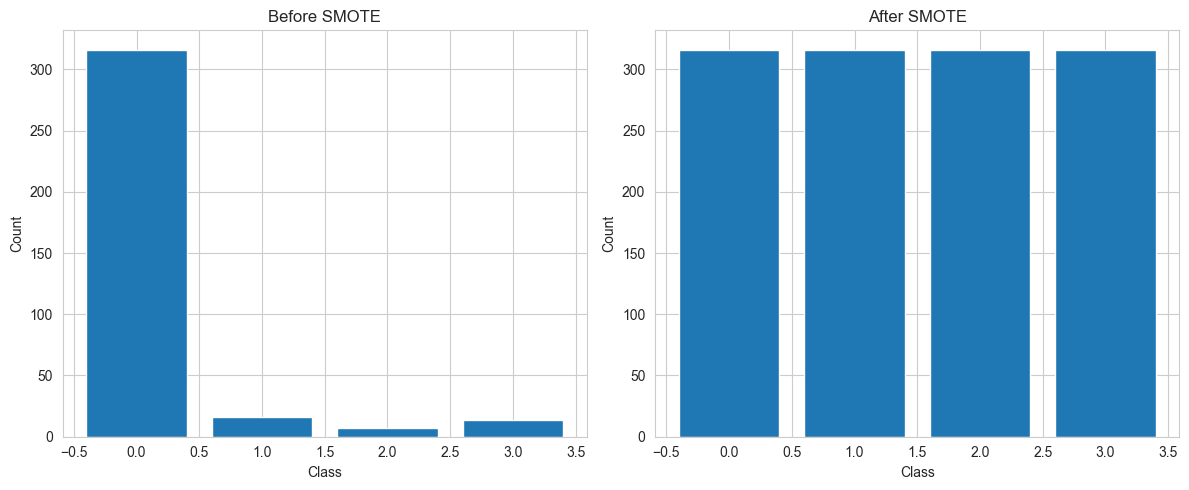

In [27]:
def apply_smote(X_train, y_train, sampling_strategy='auto', k_neighbors=5):
    """Apply SMOTE to handle class imbalance"""
    
    print("Applying SMOTE...")
    print(f"Original class distribution: {Counter(y_train)}")
    
    # Apply SMOTE
    smote = SMOTE(sampling_strategy=sampling_strategy, 
                  k_neighbors=k_neighbors, 
                  random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print(f"Balanced class distribution: {Counter(y_train_balanced)}")
    print(f"Training samples increased from {len(y_train)} to {len(y_train_balanced)}")
    
    return X_train_balanced, y_train_balanced

# Apply SMOTE only to training data
X_train_balanced, y_train_balanced = apply_smote(X_train_scaled, y_train)

# Visualize the effect
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
axes[0].bar(*np.unique(y_train, return_counts=True))
axes[0].set_title('Before SMOTE')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# After SMOTE
axes[1].bar(*np.unique(y_train_balanced, return_counts=True))
axes[1].set_title('After SMOTE')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [28]:
# Create a preprocessing pipeline object to save
preprocessing_pipeline = {
    'scaler': scaler.scaler,
    'feature_names': list(feature_columns),
    'label_mapping': label_mapping,
    'encoding_mappings': encoding_maps
}

# Save all preprocessed data and pipeline
output_dir = '../data/processed/'
import os
os.makedirs(output_dir, exist_ok=True)

# Save as CSV
X_train_balanced.to_csv(f'{output_dir}X_train.csv', index=False)
X_val_scaled.to_csv(f'{output_dir}X_val.csv', index=False)
X_test_scaled.to_csv(f'{output_dir}X_test.csv', index=False)

pd.Series(y_train_balanced).to_csv(f'{output_dir}y_train.csv', index=False, header=['Category'])
pd.Series(y_val).to_csv(f'{output_dir}y_val.csv', index=False, header=['Category'])
pd.Series(y_test).to_csv(f'{output_dir}y_test.csv', index=False, header=['Category'])

# Save preprocessing pipeline
with open(f'{output_dir}preprocessing_pipeline.pkl', 'wb') as f:
    pickle.dump(preprocessing_pipeline, f)

print("="*60)
print("DATA SAVED SUCCESSFULLY")
print("="*60)
print(f"Location: {output_dir}")
print("\nFiles saved:")
print("  - X_train.csv (balanced with SMOTE)")
print("  - X_val.csv")
print("  - X_test.csv")
print("  - y_train.csv (balanced with SMOTE)")
print("  - y_val.csv")
print("  - y_test.csv")
print("  - preprocessing_pipeline.pkl")

DATA SAVED SUCCESSFULLY
Location: ../data/processed/

Files saved:
  - X_train.csv (balanced with SMOTE)
  - X_val.csv
  - X_test.csv
  - y_train.csv (balanced with SMOTE)
  - y_val.csv
  - y_test.csv
  - preprocessing_pipeline.pkl


In [29]:
print("="*60)
print("PREPROCESSING PIPELINE SUMMARY")
print("="*60)

summary = f"""
1. DATA CLEANING
   - Duplicates removed: {cleaner.cleaning_report.get('duplicates_removed', 0)}
   - Missing values handled: {cleaner.cleaning_report.get('missing_values_removed', 0)}
   - Outliers found: {cleaner.cleaning_report.get('outliers_found', 0)}

2. CLASS IMBALANCE HANDLING
   - Merged 'Suspect' with 'Hepatitis' (too few samples)
   - Applied SMOTE to training set
   - Final class distribution: Balanced

3. FEATURE ENGINEERING
   - Medical ratios: AST/ALT, ALB/Globulin, ALP/ALT
   - Abnormal indicators: 5 binary features
   - Age groups: 5 categories
   - Severity score: Composite metric

4. DATA SPLITS
   - Training:   60% ({X_train.shape[0]} -> {len(y_train_balanced)} after SMOTE)
   - Validation: 20% ({X_val.shape[0]} samples)
   - Test:       20% ({X_test.shape[0]} samples)

5. FEATURE SCALING
   - Method: StandardScaler
   - Fitted on: Training set only
   - Applied to: All sets

6. FINAL DIMENSIONS
   - Features: {X_train_balanced.shape[1]}
   - Classes: 4 (0: Healthy, 1: Hepatitis, 2: Fibrosis, 3: Cirrhosis)
   
Data is now ready for model training!
"""

print(summary)

# Save summary to file with UTF-8 encoding
with open(f'{output_dir}preprocessing_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

PREPROCESSING PIPELINE SUMMARY

1. DATA CLEANING
   - Duplicates removed: 0
   - Missing values handled: 26
   - Outliers found: 92

2. CLASS IMBALANCE HANDLING
   - Merged 'Suspect' with 'Hepatitis' (too few samples)
   - Applied SMOTE to training set
   - Final class distribution: Balanced

3. FEATURE ENGINEERING
   - Medical ratios: AST/ALT, ALB/Globulin, ALP/ALT
   - Abnormal indicators: 5 binary features
   - Age groups: 5 categories
   - Severity score: Composite metric

4. DATA SPLITS
   - Training:   60% (353 -> 1264 after SMOTE)
   - Validation: 20% (118 samples)
   - Test:       20% (118 samples)

5. FEATURE SCALING
   - Method: StandardScaler
   - Fitted on: Training set only
   - Applied to: All sets

6. FINAL DIMENSIONS
   - Features: 22
   - Classes: 4 (0: Healthy, 1: Hepatitis, 2: Fibrosis, 3: Cirrhosis)

Data is now ready for model training!

